Some libraries to import

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from sklearn.model_selection import train_test_split
import numpy as np

2024-12-24 22:34:34.932391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 22:34:34.942442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735076074.954466   71640 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735076074.958301   71640 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 22:34:34.969915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Choosing to work with the GPU for faster training

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
    except RuntimeError as e:
        print(e)

W0000 00:00:1735076076.914137   71640 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Importing data

In [3]:
commands = []

with open('data.txt', 'r') as file:
    for line in file:
      if line:
        commands.append(line.strip())

# commands

Tokenization

In [4]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(commands)

Sequencing

In [5]:
sequences = tokenizer.texts_to_sequences(commands)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Input Output sequences

In [6]:
input_sequences = []
target_sequences = []

for seq in sequences:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        target_sequences.append(seq[i])

Padding

In [7]:
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = np.array(target_sequences)

Train_text spliting

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input_sequences,target_sequences, test_size=0.2)

Parameter loading

In [9]:
import configparser
################
# reading 
################
config = configparser.ConfigParser()
config.read('best_hyperparameters.ini')

# Access hyperparameters
embedding_dim = config.getint('Hyperparameters', 'embedding_dim')
rnn_units = config.getint('Hyperparameters', 'rnn_units')
dropout_rate = config.getfloat('Hyperparameters', 'dropout_rate')
learning_rate = config.getfloat('Hyperparameters', 'learning_rate')
batch_size = config.getint('Hyperparameters', 'batch_size')
top_k = config.getint('Hyperparameters', 'top_k')
activation = config.get('Hyperparameters', 'activation')
activation

'softmax'

Model building

In [10]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_len),
    SimpleRNN(rnn_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(vocab_size, activation=activation)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='sparse_categorical_crossentropy', 
    metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=top_k)])
model.summary()

/home/natsu/Desktop/shell_next_word_prediction/rnn/.rnn/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Fitting to data

In [11]:
history = model.fit(x_train, y_train, epochs=150, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))

Epoch 1/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.0958 - sparse_top_k_categorical_accuracy: 0.1740 - val_loss: 4.8636 - val_sparse_top_k_categorical_accuracy: 0.3277
Epoch 2/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5805 - sparse_top_k_categorical_accuracy: 0.3699 - val_loss: 4.2226 - val_sparse_top_k_categorical_accuracy: 0.4378
Epoch 3/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0530 - sparse_top_k_categorical_accuracy: 0.4300 - val_loss: 3.9514 - val_sparse_top_k_categorical_accuracy: 0.4715
Epoch 4/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7172 - sparse_top_k_categorical_accuracy: 0.4768 - val_loss: 3.7033 - val_sparse_top_k_categorical_accuracy: 0.5076
Epoch 5/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4605 - sparse_top_k_categorical_accuracy: 0.5116 - val_loss: 3.5590 - val_sparse_top_k_categorical_accuracy: 0.5316
Epoch 6/150
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.2705 - sparse_top_k_categorical_accuracy: 

Extraction statistics

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_top_k_categorical_accuracy']
val_accuracy = history.history['val_sparse_top_k_categorical_accuracy']
epochs = range(1, len(train_loss) + 1)

Graphs

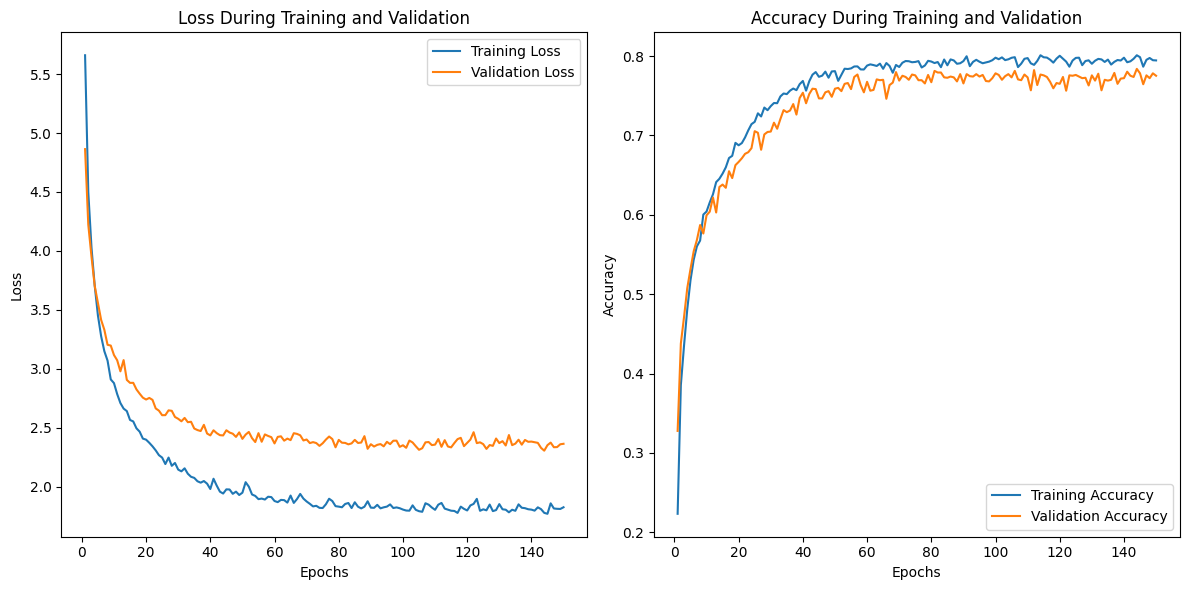

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Model evaluation

In [16]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3630 - sparse_top_k_categorical_accuracy: 0.7916
Test Loss: 2.363799571990967
Test Accuracy: 0.7752293348312378


Saving the model

In [17]:
model.save("rnn_model.keras")

Saving the tokenizer

In [18]:
import pickle

with open("rnn_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)